# Plug-and-Play Image Restoration

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2324/tp9_pnp.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/><br/>

In this practical session, we will implement **plug-and-play algorithms with the gradient-step denoiser**.

In [13]:
import numpy as np
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import time

import torch
print(torch.__version__)
pi = torch.pi
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

!pip install pytorch-lightning
# !pip install bm3d
# !pip install deepinv
# or last version of deepinv:
!pip install git+https://github.com/deepinv/deepinv.git#egg=deepinv
import deepinv as dinv

# Uncomment these two lines to download the files for this session
!wget https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
!unzip tp9.zip

2.5.1+cu121
cpu
  Cloning https://github.com/deepinv/deepinv.git to /tmp/pip-install-z9vmlbc5/deepinv_186e793c55694aa2a4d98c1285b98cd6
  Running command git clone --filter=blob:none --quiet https://github.com/deepinv/deepinv.git /tmp/pip-install-z9vmlbc5/deepinv_186e793c55694aa2a4d98c1285b98cd6
  Resolved https://github.com/deepinv/deepinv.git to commit 859392c97c21f4a14e2fa897a88f4b8602f92c56
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-11-19 21:55:49--  https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 501814458 (479M) [application/zip]
Saving to: ‘tp9.zip.1’

tp9.zip.1           100%[===================>] 478.57M  31

In [14]:
def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    rmse = np.sqrt(np.mean((np.array(uref.cpu())-np.array(ut.cpu()))**2))
    return 20*np.log10(M/rmse)

def tensor2im(x):
    return x.detach().cpu().permute(2,3,1,0).squeeze().clip(0,1)

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,vmin=0,vmax=1,z=2,order=0,titre='',displayfilename=False):
    # By default, values are scaled with black=0 and white=1
    # In order to adapt the dynamics to the image, enter vmin and vmax as None
    im = im.detach().cpu().permute(2,3,1,0).squeeze()
    imin= np.array(im).astype(np.float32)
    channel_axis = 2 if len(im.shape)>2 else None
    imin = rescale(imin, z, order=order, channel_axis=channel_axis)
    if normalize:
        if vmin is None:
            vmin = imin.min()
        if vmax is None:
            vmax = imin.max()
        imin-=vmin
        if np.abs(vmax-vmin)>1e-10:
            imin = (imin.clip(vmin,vmax)-vmin)/(vmax-vmin)
        else:
            imin = vmin
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))


# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

<br/><br/><br/>

# Exercise 1: Plug-and-Play Image Deblurring (with periodic convolution)

First, we load a clean image and a blur kernel.

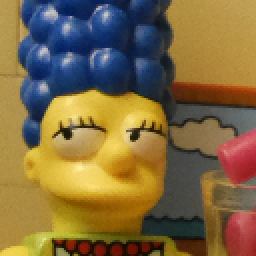

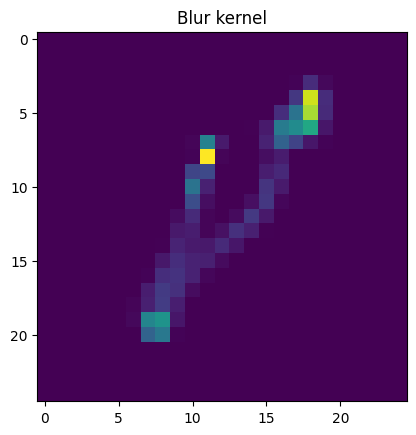

In [15]:
# Open the image
x0 = torch.tensor(plt.imread('im/simpson512crop.png'),device=device)
# x0 = torch.tensor(plt.imread('im/parrots.png'),device=device); x0 = x0[100:356,370:626,:]
# x0 = torch.tensor(plt.imread('im/marge2.png'),device=device)
# x0 = torch.tensor(plt.imread('im/simpson512.png'),device=device)
M,N,C = x0.shape
# Permute dimensions to fit tensor convention
x0 = x0.permute(2,0,1).unsqueeze(0).contiguous()

viewimage(x0)

# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
k = torch.zeros((M,N),device=device)
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
k = k[None,None,:,:]
fk = fft2(k)
fk_conj = np.conj(fk)

## Forward Model

Implement the forward model
$$ y = A(x_0) + \xi $$
where $\xi \sim \mathcal{N}(0,\nu^2 \mathsf{Id})$.
Write functions implementing the operator $A(x)$, the data-fidelity term $f(x)$, and its proximal operator $\mathsf{Prox}_{\tau f}$.

The data fidelity term is basically how far the estimated solution is from the actual image. Given the Gaussian perturbation term, the likelihood function is

$$f(x) = -\ln(p(y | A(x_0))) = \frac{||y - A(x)||_2^2}{2\nu^2}.$$

As usual, the likelihood is sought to be maximized. In the bayesian framework though, a regularization term is naturally added.

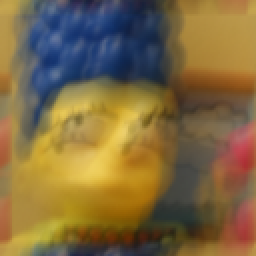

In [25]:
nu = .01  # noise level
torch.manual_seed(1)  # fix random seed for reproducibility

# Define corresponding operator and data-fidelity
def A(x):
    return ifft2(fk*fft2(x)).real

def f(x):
    return 1/(2*nu**2)*torch.sum((y - A(x))**2)

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)

Noise = 0.001*torch.randn(x0.shape)
y = A(x0) + Noise
viewimage(y)

## Test the Gradient-Step Denoiser and the corresponding regularization

In the following, we will use several algorithms to minimize
$$F(x) = f(x) + \lambda g_{\sigma}(x)$$
where $g_{\sigma}$ is the regularization function linked to the gradient-step denoiser.

The function $g_{\sigma}$ is accessible through `D.potential`, and the corresponding gradient-step denoiser then writes
$$ D_{\sigma} = \mathsf{Id} - \nabla g_{\sigma} .$$
<br/><br/>

In the following cell, test the gradient-step denoiser on a noisy image `xnoisy`.

/usr/local/lib/python3.10/dist-packages/deepinv/models/GSPnP.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained, map_location=lambda storage,

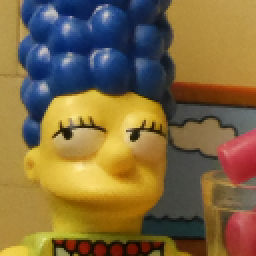

In [18]:
# load the gradient-step denoiser
D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt').to(device)
# D=dinv.models.GSDRUNet(pretrained='ckpts/Prox-DRUNet.ckpt', train=False).to(device)

xnoisy = x0 + nu*torch.randn_like(x0,device=device)
x = xnoisy.clone().requires_grad_(True)
px = D.potential(x, sigma = nu)
grad = torch.autograd.grad(px,x)[0]

Dx = xnoisy-grad

viewimage(Dx)

# # alternately, you can use
# Dx = D(xnoisy,sigma=nu)
# # but this causes a requires_grad problem on a previous version of deepinv.

## PnP-GD with Gradient-Step Denoiser

Implement the gradient descent algorithm
$$ x_{k+1} = x_k - \tau \nabla F(x_k) .$$
Along the iterations, track the function values $F(x_k)$, the PSNR and the residual norm $r_k = \frac{\|x_{k}-x_{k-1}\|}{\|x_0\|}$.

[   0/ 200] [0.00000 s] PSNR = 18.65
[  10/ 200] [14.43114 s] PSNR = 20.40, F(x) = 33375.515625, tau = 0.000200


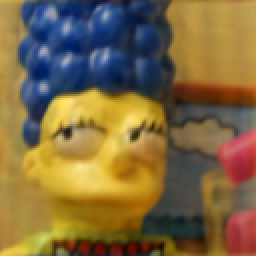

[  20/ 200] [28.87163 s] PSNR = 19.58, F(x) = 23389.896484, tau = 0.000200


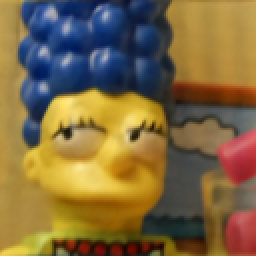

[  30/ 200] [43.27733 s] PSNR = 19.31, F(x) = 21185.785156, tau = 0.000200


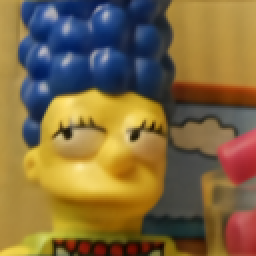

[  40/ 200] [57.70739 s] PSNR = 19.17, F(x) = 20249.798828, tau = 0.000200


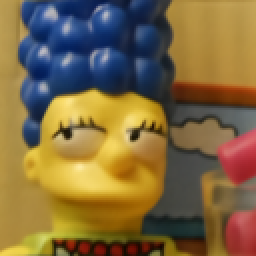

[  50/ 200] [72.08121 s] PSNR = 19.08, F(x) = 19771.654297, tau = 0.000200


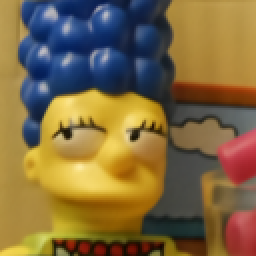

[  60/ 200] [86.59087 s] PSNR = 19.01, F(x) = 19481.666016, tau = 0.000200


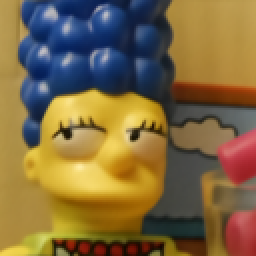

[  70/ 200] [101.34488 s] PSNR = 18.97, F(x) = 19299.613281, tau = 0.000200


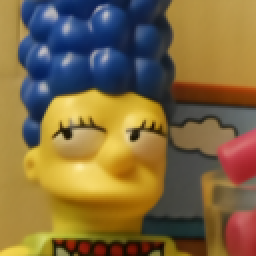

[  80/ 200] [115.73639 s] PSNR = 18.93, F(x) = 19176.708984, tau = 0.000200


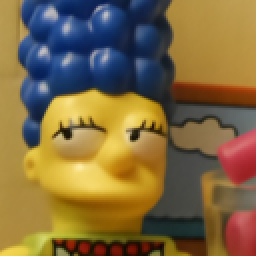

[  90/ 200] [130.18298 s] PSNR = 18.90, F(x) = 19111.912109, tau = 0.000200


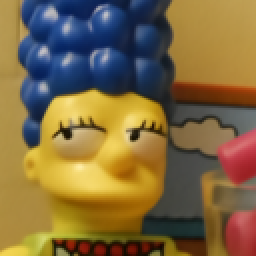

[ 100/ 200] [145.05473 s] PSNR = 18.88, F(x) = 19077.736328, tau = 0.000200


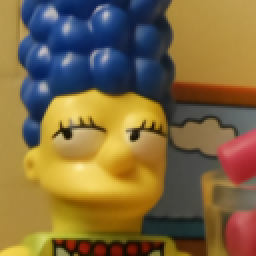

[ 110/ 200] [159.51537 s] PSNR = 18.86, F(x) = 19057.990234, tau = 0.000200


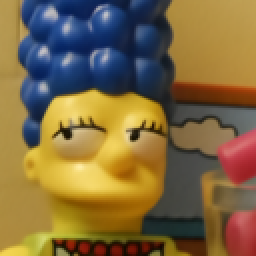

[ 120/ 200] [174.98955 s] PSNR = 18.85, F(x) = 19045.867188, tau = 0.000200


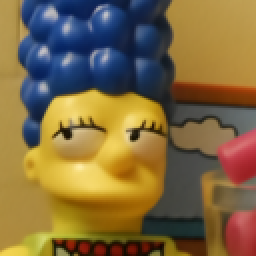

[ 130/ 200] [197.95063 s] PSNR = 18.84, F(x) = 19038.150391, tau = 0.000200


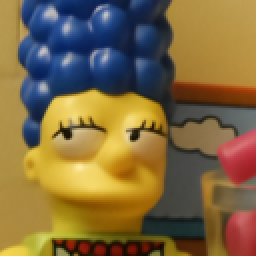

[ 140/ 200] [214.49123 s] PSNR = 18.83, F(x) = 19033.044922, tau = 0.000200


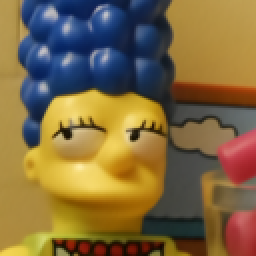

[ 150/ 200] [229.11980 s] PSNR = 18.82, F(x) = 19029.589844, tau = 0.000200


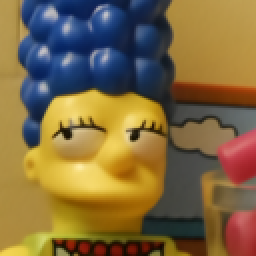

[ 160/ 200] [245.10596 s] PSNR = 18.82, F(x) = 19027.185547, tau = 0.000200


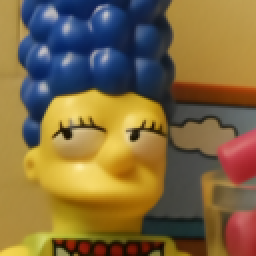

[ 170/ 200] [259.95057 s] PSNR = 18.81, F(x) = 19025.474609, tau = 0.000200


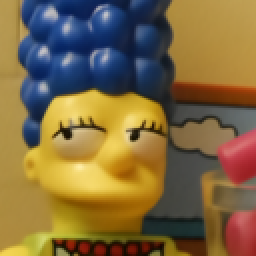

[ 180/ 200] [274.66613 s] PSNR = 18.81, F(x) = 19024.222656, tau = 0.000200


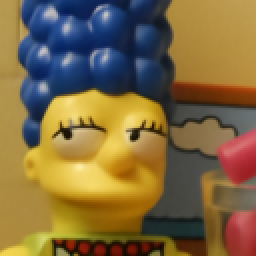

[ 190/ 200] [290.07119 s] PSNR = 18.81, F(x) = 19023.316406, tau = 0.000200


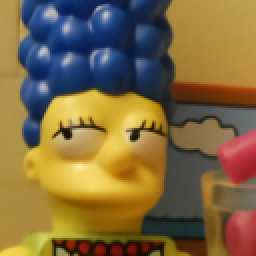

[ 200/ 200] [304.62121 s] PSNR = 18.81, F(x) = 19022.611328, tau = 0.000200


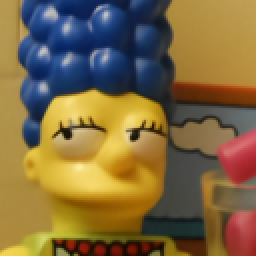

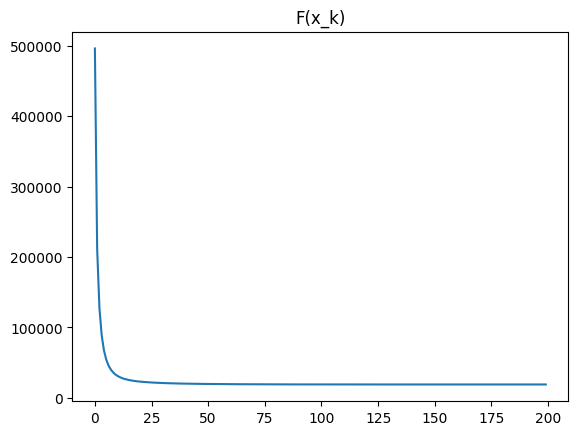

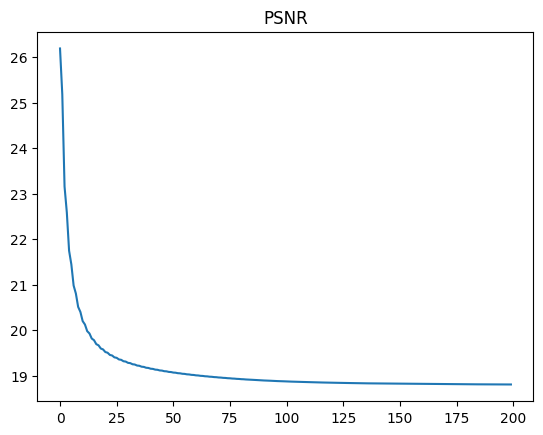

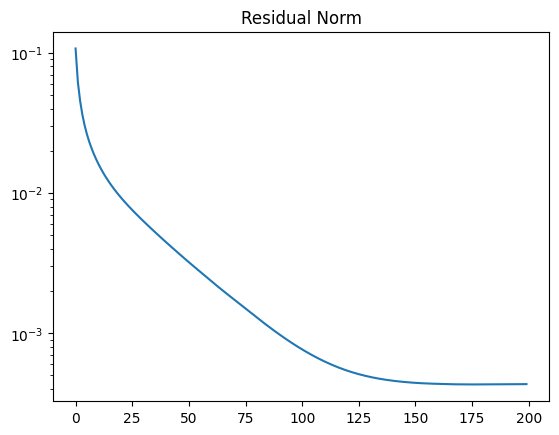

In [19]:
# GSDRUNET
# https://deepinv.github.io/deepinv/stubs/deepinv.models.GSDRUNet.html
D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt').to(device)

tau = 2e-4
s = 1.8*nu  # strength of the denoiser (sigma in the text)
lam = 1600

# Define the objective function
def F(x, lam, s):
    return f(x) + lam*D.potential(x,sigma = s)

# initialize
x = torch.clone(y).requires_grad_(True)
normxinit = torch.linalg.vector_norm(x.detach())

losstab = []
psnrtab = []
rtab = []
niter = 200
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):

    loss = F(x,lam, s)
    grad = torch.autograd.grad(loss,x)[0]
    x_prev = x.clone()
    x = x - tau*grad

    r = torch.norm(x - x_prev)/torch.norm(x0)
    psnrt = psnr(x.detach(),y)
    losstab.append(loss.item())
    psnrtab.append(psnrt)
    rtab.append(r.item())

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f, F(x) = %.6f, tau = %.6f'%(it+1,niter,time.time()-t0,psnrt,loss.item(),tau))
        viewimage(x)


plt.plot(losstab)
plt.title('F(x_k)')
plt.show()

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.show()

# save results
x_gsgd = x.detach().clone()
losstab_gsgd = losstab.copy()
psnrtab_gsgd = psnrtab.copy()
rtab_gsgd = rtab.copy()

## PnP-PGD with Gradient-Step Denoiser And Backtracking

Implement the proximal gradient descent algorithm
$$ x_{k+1} = \mathsf{Prox}_{\tau f}\big(x_k - \tau  \lambda \nabla g_{\sigma}(x_k) \big) .$$
Along the iterations, track the function values $F(x_k)$, the PSNR and the residual norm $r_k = \frac{\|x_{k}-x_{k-1}\|}{\|x_0\|}$.

Let us denote by $T_\tau(x_k) = \mathsf{Prox}_{\tau f}(x_k - \tau  \lambda \nabla g_{\sigma}(x_k))$ the PGD update.

Modify your code in order to include the backtracking procedure: at each iteration,
$$ \textbf{while} \quad  F(x_k) - F(T_\tau(x_k)) < \frac{\gamma}{\tau} \|T_\tau(x_k) - x_k\|^2 \quad \textbf{do} \quad \tau \leftarrow \eta \tau .$$
You may take $\gamma = 0.4, \eta = 0.9$.

Modify your code so that the output image $\tilde{x}_k$ (variable `xvisu`) is the one obtained before the last proximal step:
$$ x_{k+1} = \mathsf{Prox}_{\tau f}(\tilde{x}_k) .$$
You may display `xvisu` instead of `x` and track PSNR with `xvisu`. (In order to improve visual quality, it is useful not to apply the last data-fidelity step which adds back some noise.) <br/>
You may also display the value $F(\tilde{x}_k)$ which corresponds to values obtained by the HQS algorithm
$$ \tilde{x}_{k+1} = \tilde{D}_\sigma(\mathsf{Prox}_{\tau f}(\tilde{x}_k))$$
where $\tilde{D}_\sigma = \mathsf{Id} - \tau \lambda\nabla g_\sigma$ is (by abuse) seen here as a proximal regularization step.

We can implement the proximal operator of the data-fidelity term with:
$$\mathsf{Prox}_{\tau f}(x) = \left( \frac{1}{\nu^2} A^T A + \frac{1}{\tau} \mathsf{Id} \right)^{-1} \left( \frac{1}{\nu^2} A^T y + \frac{1}{\tau} x \right) .$$
Since $A$ is here a periodic convolution, this calculation can be done in Fourier domain.

In Fourier domain, it gives :

$$
\widehat{\mathsf{Prox}}_{\tau f}(x) = \frac{\frac{1}{\nu^2}\bar{\hat{k}}\hat y + \frac{1}{\tau}\hat x}{\frac{1}{\nu^2}|\hat{k}|^2 + \frac{1}{\tau}}
$$
It has to be understood term-by-term. The $\frac{1}{\tau}$ term is like a Thykonov regularization coefficient.

In [36]:
def prox_f(x,tau):
    return ifft2((1/nu**2*fk_conj*fft2(y) + 1/tau*fft2(x))/(1/nu**2*np.abs(fk)**2 + 1/tau)).real

[   0/ 100] [0.00000 s] PSNR = 18.65
[  10/ 100] [36.62599 s] PSNR = 20.73, F(x) = 30648.351562, tau = 0.000200


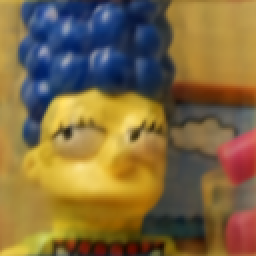

[  20/ 100] [71.77125 s] PSNR = 19.67, F(x) = 22306.845703, tau = 0.000200


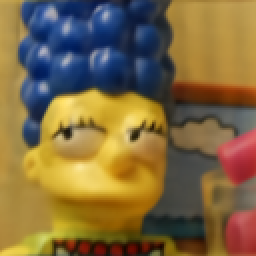

[  30/ 100] [108.36890 s] PSNR = 19.34, F(x) = 20658.089844, tau = 0.000200


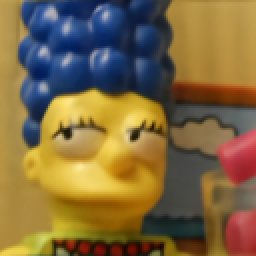

[  40/ 100] [145.30836 s] PSNR = 19.19, F(x) = 19983.341797, tau = 0.000200


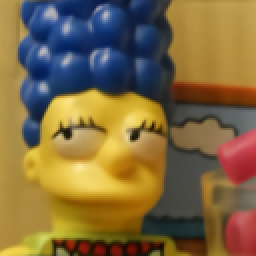

[  50/ 100] [180.70318 s] PSNR = 19.09, F(x) = 19632.400391, tau = 0.000200


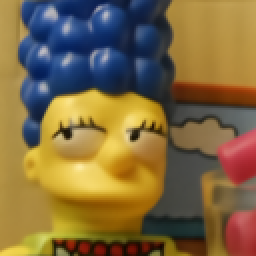

[  60/ 100] [217.06955 s] PSNR = 19.02, F(x) = 19404.638672, tau = 0.000200


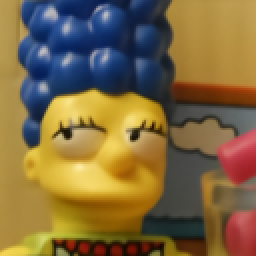

[  70/ 100] [253.66613 s] PSNR = 18.97, F(x) = 19256.789062, tau = 0.000200


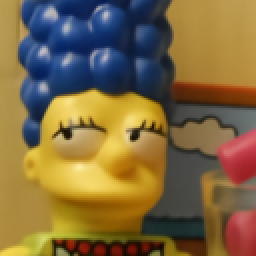

[  80/ 100] [289.08422 s] PSNR = 18.93, F(x) = 19154.484375, tau = 0.000200


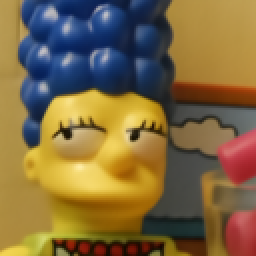

[  90/ 100] [325.44856 s] PSNR = 18.90, F(x) = 19100.804688, tau = 0.000200


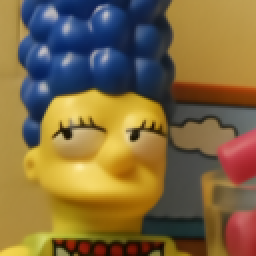

[ 100/ 100] [362.17092 s] PSNR = 18.88, F(x) = 19071.599609, tau = 0.000200


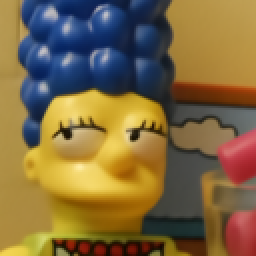

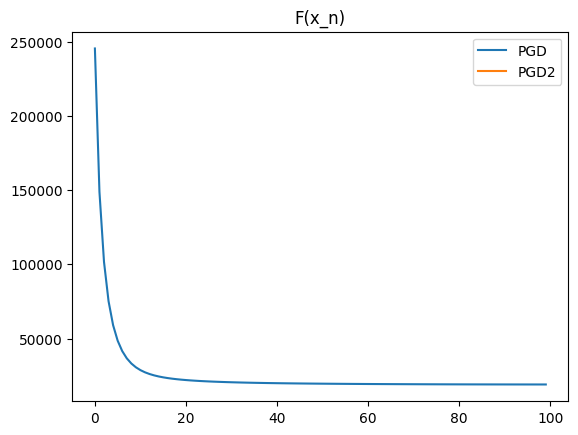

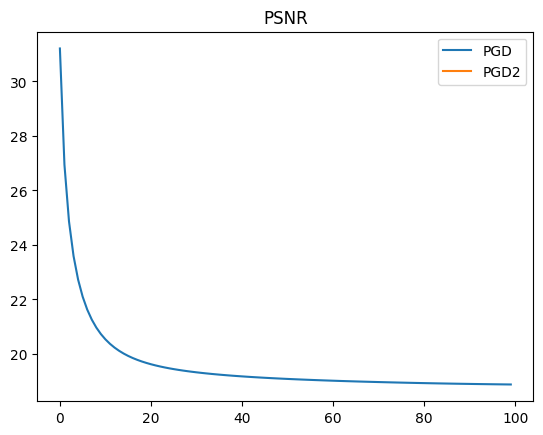

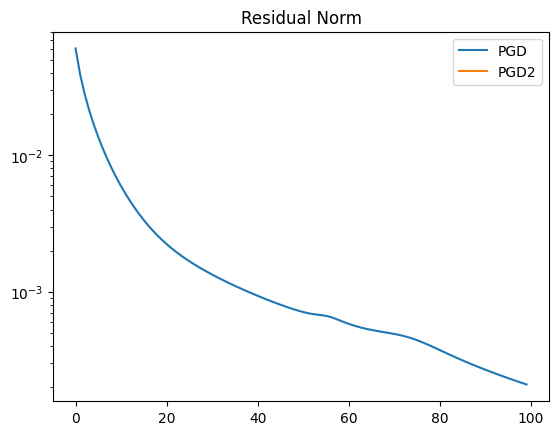

In [40]:
# GSDRUNET
# https://deepinv.github.io/deepinv/stubs/deepinv.models.GSDRUNet.html
D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt').to(device)

# Parameters
tau = 2e-4
s = 1.8*nu  # strength of the denoiser (sigma in the text)
lam = 1600
gamma = 10
eta = .9

# initialize
x = torch.clone(y).requires_grad_(True)
normxinit = torch.linalg.vector_norm(x.detach())
xvisuold = x.detach().clone()

losstab = []
psnrtab = []
rtab = []
# same tables for \tilde{x} :
losstab2 = []
psnrtab2 = []
rtab2 = []

niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    px = D.potential(x, sigma = s)
    grad = torch.autograd.grad(px,x)[0]

    xvisu = x - tau*lam*grad
    x_inter = prox_f(xvisu,tau)
    x_prev = x

    while (F(x, lam, s) - F(x_inter, lam, s) < gamma/tau*torch.sum(x_inter - x)**2):
      tau *= eta
      xvisu = x - tau*lam*grad
      x_inter = prox_f(xvisu,tau)

    x = x_inter
    Fxnew = F(x, lam, s)

    r = torch.norm(x - x_prev)/torch.norm(x0)

    #Peak signal to noise ration
    psnrt2 = psnr(x.detach(),y)

    losstab.append(Fxnew.item())
    psnrtab.append(psnrt2)
    rtab.append(r.item())
    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f, F(x) = %.6f, tau = %.6f'%(it+1,niter,time.time()-t0,psnrt2,Fxnew.item(),tau))
        viewimage(xvisu)

plt.plot(losstab,label='PGD')
plt.plot(losstab2,label='PGD2')
plt.title('F(x_n)')
plt.legend()
plt.show()

plt.plot(psnrtab,label='PGD')
plt.plot(psnrtab2,label='PGD2')
plt.title('PSNR')
plt.legend()
plt.show()

plt.semilogy(rtab,label='PGD')
plt.semilogy(rtab2,label='PGD2')
plt.title('Residual Norm')
plt.legend()
plt.show()

# save results
x_gspgd = x.detach().clone()
losstab_gspgd = losstab.copy()
psnrtab_gspgd = psnrtab.copy()
rtab_gspgd = rtab.copy()

x_gspgd2 = xvisu.clone()
losstab_gspgd2 = losstab2.copy()
psnrtab_gspgd2 = psnrtab2.copy()
rtab_gspgd2 = rtab2.copy()

# # save results
# tmp_x_gspgd = x.detach().clone()
# tmp_losstab_gspgd = losstab.copy()
# tmp_psnrtab_gspgd = psnrtab.copy()
# tmp_rtab_gspgd = rtab.copy()

# tmp_x_gspgd2 = xvisu.clone()
# tmp_losstab_gspgd2 = losstab2.copy()
# tmp_psnrtab_gspgd2 = psnrtab2.copy()
# tmp_rtab_gspgd2 = rtab2.copy()

## PGD with standard DRUNET denoiser

Implement the PGD algorithm
$$ x_{k+1} = D_\sigma(x_k - \tau \nabla f(x_k)) $$
by taking directly $D_\sigma$ as the DRUNET (or GS-DRUNET) denoiser.

/usr/local/lib/python3.10/dist-packages/deepinv/models/drunet.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_drunet = torch.load(


[   0/ 100] [0.00000 s] PSNR = 18.65
[  10/ 100] [20.10411 s] PSNR = 27.06


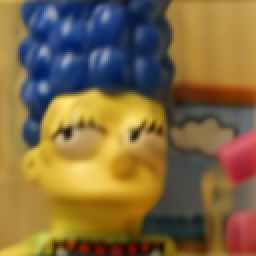

[  20/ 100] [33.95010 s] PSNR = 29.13


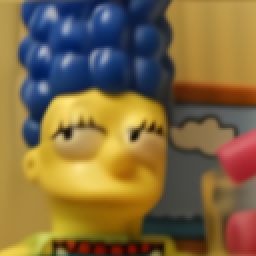

[  30/ 100] [45.82413 s] PSNR = 30.13


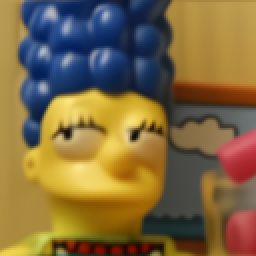

[  40/ 100] [57.29047 s] PSNR = 30.71


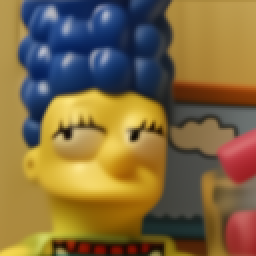

[  50/ 100] [68.32922 s] PSNR = 31.08


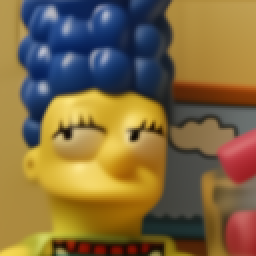

[  60/ 100] [80.26851 s] PSNR = 31.31


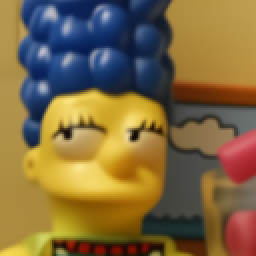

[  70/ 100] [92.19143 s] PSNR = 31.44


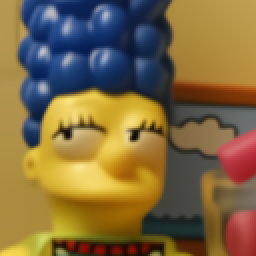

[  80/ 100] [104.12734 s] PSNR = 31.52


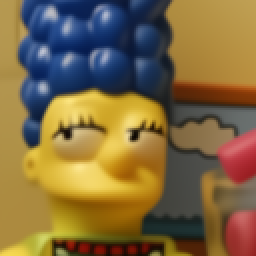

[  90/ 100] [116.03852 s] PSNR = 31.57


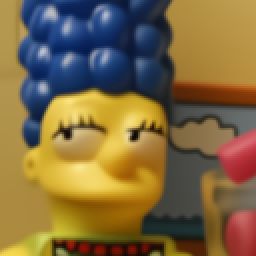

[ 100/ 100] [128.44066 s] PSNR = 31.61


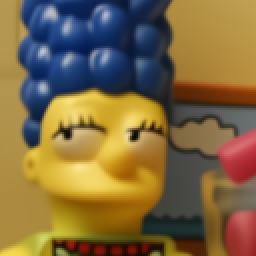

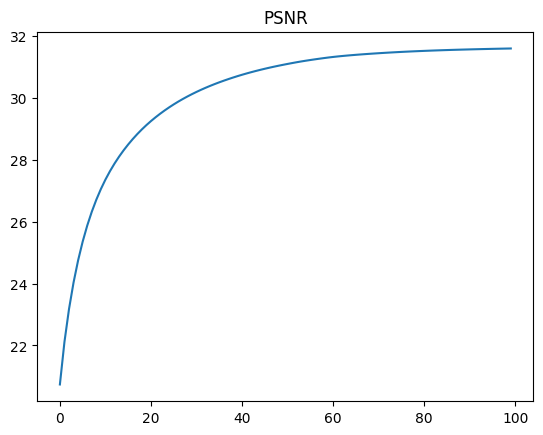

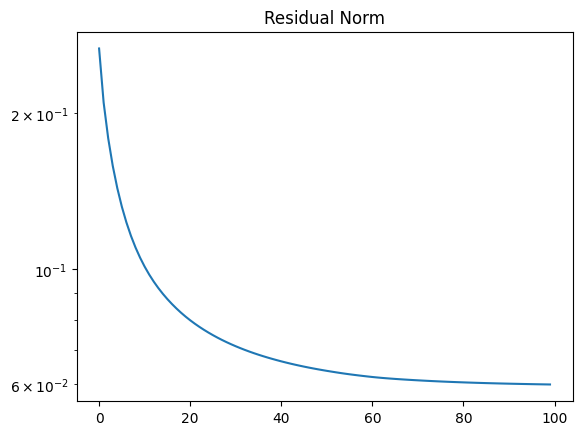

In [17]:
D = dinv.models.DRUNet(pretrained='ckpts/drunet_color.pth').to(device)
# D = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_color.pth').to(device)
# D = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_lipschitz_color.pth').to(device)

tau = 1.9*nu**2
s = 2*nu  # strength of the denoiser

# tau = .1*nu**2
# s= .1*nu   # make things diverge for DRUNet

# initialize
x = y.clone()
normxinit = torch.linalg.vector_norm(x)

psnrtab = []
rtab = []
niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    xt = x.clone().requires_grad_(True)
    fx = f(xt)
    grad = torch.autograd.grad(outputs=fx, inputs=xt)[0]
    with torch.no_grad():
        xnew = x-tau*grad
        Dxnew = D(xnew,sigma=s)
        x = Dxnew
        xold = xnew.clone()
        Dxold = Dxnew.clone()

    psnrt = psnr(x0,x)
    r = torch.linalg.vector_norm(xt.detach()-x0)/normxinit
    psnrtab.append(psnrt)
    rtab.append(r.cpu())

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

x_pgd = x.detach().clone()
losstab_pgd = losstab.copy()
psnrtab_pgd = psnrtab.copy()
rtab_pgd = rtab.copy()

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.show()


## Baseline Comparisons with explicit regularizations (Tychonov or SmoothTV)

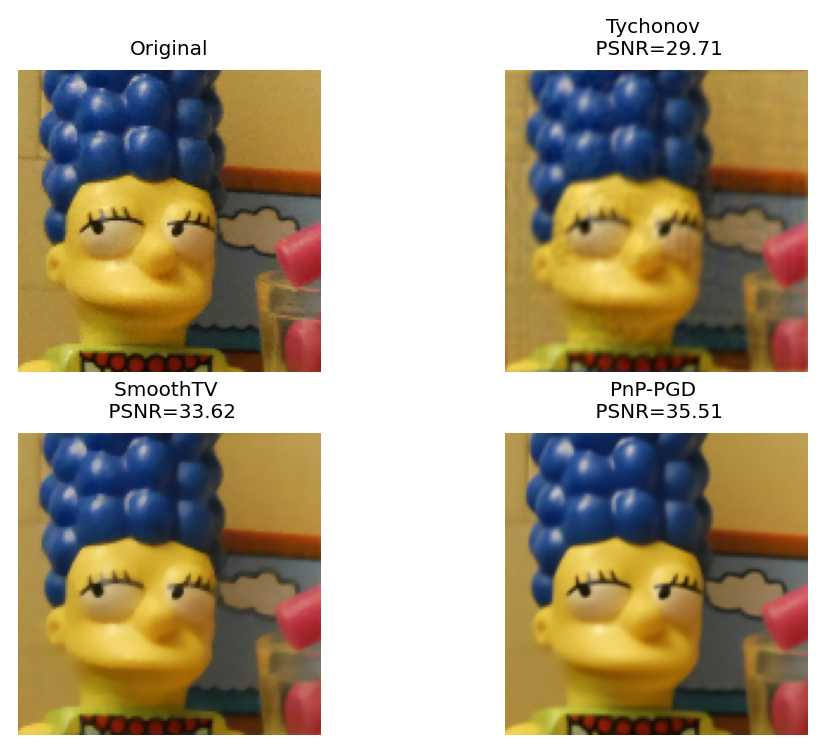

In [14]:
# Deblurring with Tychonov Regularization
def tych_deblur(y,k,lam=0.01):
    _,_,M,N = y.shape
    xi = torch.arange(M)
    ind = (xi>M/2)
    xi[ind] = xi[ind]-M
    zeta = torch.arange(N)
    ind = (zeta>N/2)
    zeta[ind] = zeta[ind]-N
    Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')
    Xi = Xi[None,None,:,:].to(device)
    Zeta = Zeta[None,None,:,:].to(device)
    fh = torch.conj(fk)/(torch.abs(fk)**2 + 8 * lam * (torch.sin(pi*Xi/M)**2 + torch.sin(pi*Zeta/N)**2))
    return ifft2(fft2(y)*fh).real

xtych = tych_deblur(y,k)

# Smooth TV regularization
def stv_deblur(A,y,xinit,niter=1000,lam=0.002,ep=0.01,lr=None):
    if lr is None:
        lr = 1.9/(1+lam*8/ep)
    x = xinit.clone().requires_grad_(True)
    optim = torch.optim.SGD([x], lr=lr)
    losslist = []
    for it in range(niter):
        d1 = torch.roll(x,-1,2) - x
        d2 = torch.roll(x,-1,3) - x
        reg = torch.sum(torch.sqrt(ep**2+d1**2+d2**2))
        loss = torch.sum((A(x)-y)**2) + lam*reg
        losslist.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    return x.detach(),losslist

xtv,_ = stv_deblur(A,y,y.clone())

# # Display the results
# print('PSNR(x0,xtych) = %.2f'%psnr(x0,xtych))
# viewimage(xtych)
# print('PSNR(x0,xtv) = %.2f'%psnr(x0,xtv))
# viewimage(xtv)

plt.figure(dpi=180)
plt.subplot(2,2,1)
plt.imshow(tensor2im(x0), cmap='gray')
plt.title('Original',fontsize=8)
# plt.imshow(tensor2im(y), cmap='gray')
# plt.title('Degraded \n PSNR='+str2(psnr(x0,y)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(tensor2im(xtych), cmap='gray')
plt.title('Tychonov \n PSNR='+str2(psnr(x0,xtych)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(tensor2im(xtv), cmap='gray')
plt.title('SmoothTV \n PSNR='+str2(psnr(x0,xtv)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(tensor2im(x_gspgd), cmap='gray')
plt.title('PnP-PGD \n PSNR='+str2(psnr(x0,x_gspgd)),fontsize=8)
plt.axis('off')
plt.show()

With smoothTV regularization, the image is less blurry. This type of regularization looks more efficient overall.

<br/><br/><br/>

# Exercice 2: Image Super-resolution

<br/><br/>
Use your favorite plug-and-play algorithm to tackle image super-resolution in a stable way.

The direct model $Ax = (k*x)_{\downarrow p}$ is a composition of an anti-aliasing filter (e.g. Butterworth filter, see below) with a downsampling step with stride $p$.

The proximal operator remains:
$$\mathsf{Prox}_{\tau f}(x) = \left( \frac{1}{\nu^2} A^T A + \frac{1}{\tau} \mathsf{Id} \right)^{-1} \left( \frac{1}{\nu^2} A^T y + \frac{1}{\tau} x \right) .$$

Butterworth filter is a indicator function, so is in particular real and positive. It immediately follows: $\hat k = \bar{\hat k}$ and $|\hat k|^2 = \hat k$, which leads to a few simplifications.

According to this page: https://www.researchgate.net/figure/mplementation-of-downsampling-operator_fig2_361252992, the adjoint operator of Downsampling is Upsampling. The Upsampling of an image $I_0$ consists in declaring a new image array $I_1$ with dimensions $(I_0^x \times s, I_0^y \times s)$ where $s$ is the so-called stride. The entries of the new image $I_1$ are defined by: $I_1(s\times x,s \times y) =  I_0(x,y)$ for $(x,y) \in \{0, \cdots, I_0^x - 1\} \times \{0, \cdots, I_0^y - 1\}$ and $0$ otherwise.
The Upsampling operator of stride $p$ will be noted $\uparrow p$.

The adjoint operator acts then as $A^\text{T} y = k\star y_{\uparrow p}$.

I can not go further, I do not know how to implement this idea, in particular how to inverse the operator $\frac{A^TA}{\nu^2} + \frac{1}{\tau}I$.

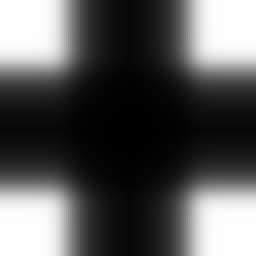

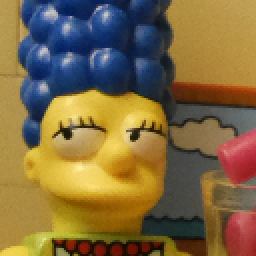

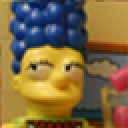

In [48]:
# Adjust the framework to address super-resolution with smoothed TV
# For anti-aliasing, you may use the Butterworth filter of order n and cut-off frequency fc
# given below
def conv(L):
    return ifft2(bf*fft2(L)).real

def downsampling(L,stride = 2):
  return L[:,:,::stride,::stride]

def upsampling(L, stride = 2):
    size = list(L.size())
    size[2] *= 2
    size[3] *= 2
    R = torch.zeros(*size)
    R[:,:,::stride,::stride] = L
    return R


# fc is the cut-off frequency normalized in (0,1)
def butterworth(M,N,fc=.5,order=5):
    xi = torch.arange(M)
    ind = (xi>M/2)
    xi[ind] = xi[ind]-M
    zeta = torch.arange(N)
    ind = (zeta>N/2)
    zeta[ind] = zeta[ind]-N
    Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')
    Xi = Xi[None,None,:,:].to(device)
    Zeta = Zeta[None,None,:,:].to(device)
    bf1 = 1/torch.sqrt(1+(Xi/(M*fc/2))**(2*order))
    bf2 = 1/torch.sqrt(1+(Zeta/(N*fc/2))**(2*order))
    return bf1*bf2

bf = butterworth(M,N)
viewimage(bf)

# Use example:
bf = butterworth(x0.shape[2],x0.shape[3],fc=3e-1)

def operator(x0,s = 2):
    x0f = conv(x0)
    x0f = downsampling(x0f)
    return x0f

x0f = operator(x0) #Degradation operator

def f(x, stride = 2):
    return 1/(2*nu**2)*torch.sum((x0f - operator(x, stride))**2)

viewimage(x0)
viewimage(x0f)

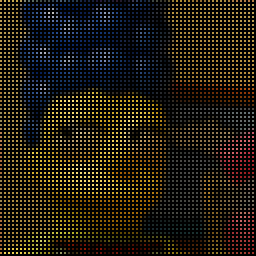

In [49]:
viewimage(upsampling(x0f, 2))

Initial Image


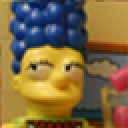

[   0/ 200] [0.00000 s] PSNR = 18.65
[  10/ 200] [14.57816 s] PSNR = 11.04, F(x) = 2916926.250000, tau = 0.000020


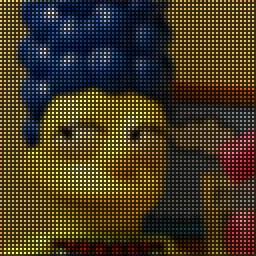

[  20/ 200] [28.97142 s] PSNR = 12.57, F(x) = 1078451.500000, tau = 0.000020


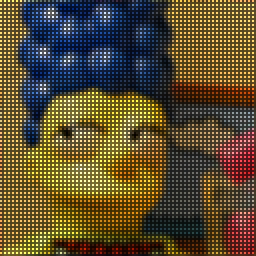

[  30/ 200] [43.85639 s] PSNR = 13.22, F(x) = 417423.093750, tau = 0.000020


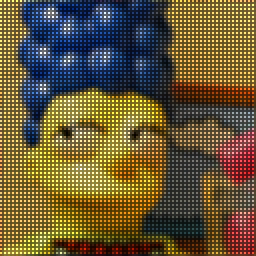

[  40/ 200] [58.56863 s] PSNR = 13.45, F(x) = 178878.468750, tau = 0.000020


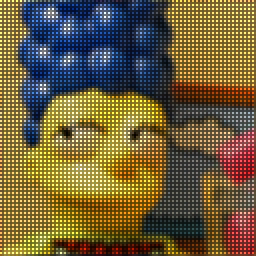

[  50/ 200] [73.40844 s] PSNR = 13.53, F(x) = 91561.898438, tau = 0.000020


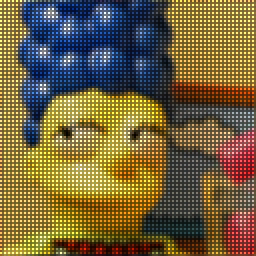

[  60/ 200] [88.37846 s] PSNR = 13.57, F(x) = 58529.617188, tau = 0.000020


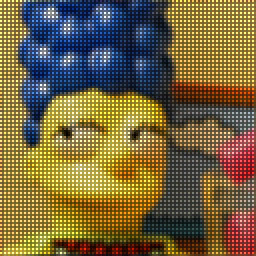

[  70/ 200] [102.89195 s] PSNR = 13.61, F(x) = 45150.492188, tau = 0.000020


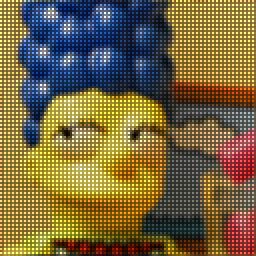

[  80/ 200] [117.31674 s] PSNR = 13.64, F(x) = 39025.894531, tau = 0.000020


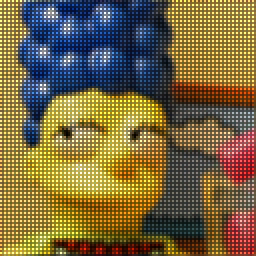

[  90/ 200] [131.83281 s] PSNR = 13.67, F(x) = 35687.328125, tau = 0.000020


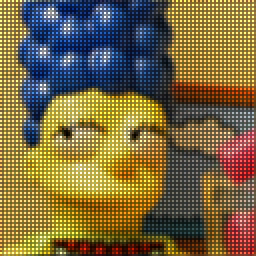

[ 100/ 200] [146.36699 s] PSNR = 13.70, F(x) = 33500.460938, tau = 0.000020


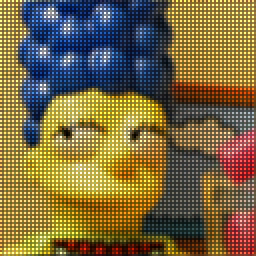

[ 110/ 200] [160.88303 s] PSNR = 13.74, F(x) = 31847.984375, tau = 0.000020


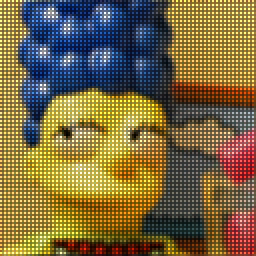

[ 120/ 200] [175.34934 s] PSNR = 13.77, F(x) = 30486.246094, tau = 0.000020


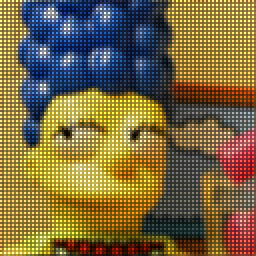

[ 130/ 200] [191.51429 s] PSNR = 13.80, F(x) = 29309.367188, tau = 0.000020


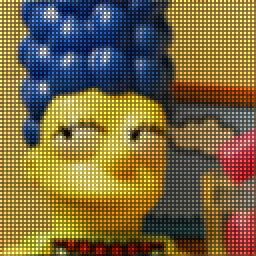

[ 140/ 200] [205.94231 s] PSNR = 13.83, F(x) = 28265.384766, tau = 0.000020


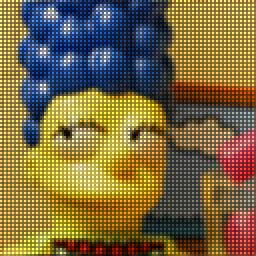

[ 150/ 200] [220.39798 s] PSNR = 13.86, F(x) = 27328.394531, tau = 0.000020


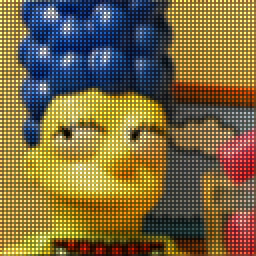

[ 160/ 200] [234.74749 s] PSNR = 13.89, F(x) = 26481.859375, tau = 0.000020


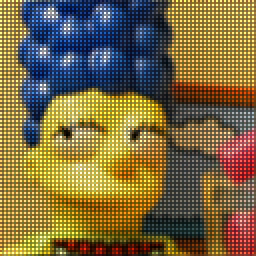

[ 170/ 200] [249.18882 s] PSNR = 13.91, F(x) = 25712.275391, tau = 0.000020


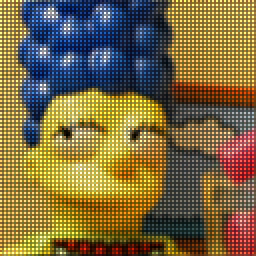

[ 180/ 200] [263.61502 s] PSNR = 13.94, F(x) = 25011.576172, tau = 0.000020


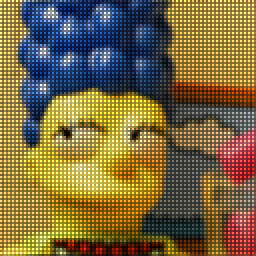

[ 190/ 200] [278.05075 s] PSNR = 13.96, F(x) = 24370.998047, tau = 0.000020


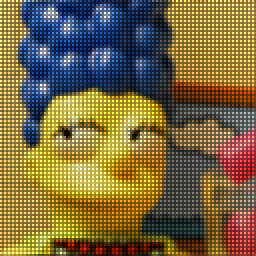

[ 200/ 200] [294.97771 s] PSNR = 13.98, F(x) = 23782.488281, tau = 0.000020


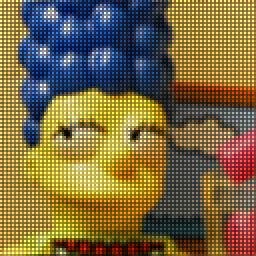

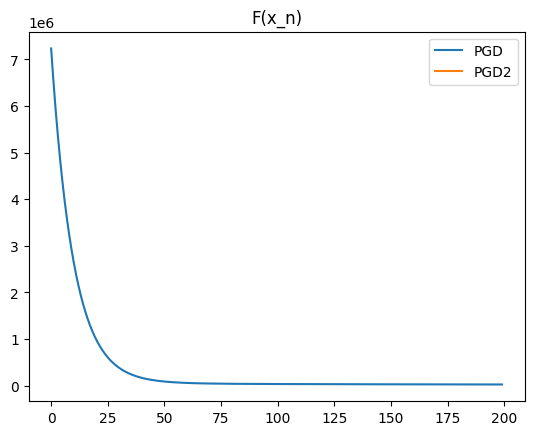

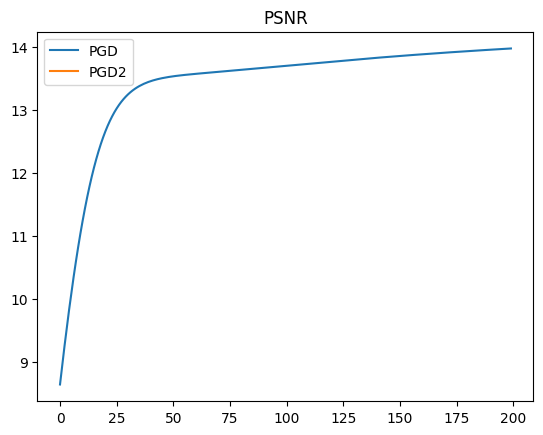

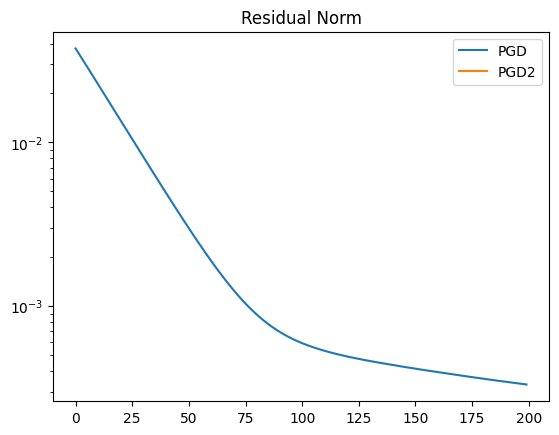

In [53]:
# GSDRUNET
# https://deepinv.github.io/deepinv/stubs/deepinv.models.GSDRUNet.html
# D = dinv.models.DRUNet(pretrained='ckpts/drunet_color.pth').to(device)
D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt').to(device)

nu = 1e-2
# Parameters
tau = 2e-5
s = 1.8*nu  # strength of the denoiser (sigma in the text)
lam = 1600 # Regularization parameter
gamma = .7
eta = .9
stride = 2

# Define the objective function
def F(x, lam, s):
    return f(x, 2) + lam*D.potential(x,sigma = s)

# initialize
x = torch.clone(x0f).requires_grad_(True)
normxinit = torch.linalg.vector_norm(x.detach())
xvisuold = x.detach().clone()
x = upsampling(x, stride)

print("Initial Image")
viewimage(x0f)

losstab = []
psnrtab = []
rtab = []
# same tables for \tilde{x} :
losstab2 = []
psnrtab2 = []
rtab2 = []

niter = 200
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    loss = F(x,lam, s)
    grad = torch.autograd.grad(loss,x)[0]
    x_prev = x.clone()
    x = x - tau*grad

    r = torch.norm(x - x_prev)/torch.norm(x0)
    psnrt = psnr(x.detach(),y)
    losstab.append(loss.item())
    psnrtab.append(psnrt)
    rtab.append(r.item())

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f, F(x) = %.6f, tau = %.6f'%(it+1,niter,time.time()-t0,psnrt,loss.item(),tau))
        viewimage(x)

plt.plot(losstab,label='PGD')
plt.plot(losstab2,label='PGD2')
plt.title('F(x_n)')
plt.legend()
plt.show()

plt.plot(psnrtab,label='PGD')
plt.plot(psnrtab2,label='PGD2')
plt.title('PSNR')
plt.legend()
plt.show()

plt.semilogy(rtab,label='PGD')
plt.semilogy(rtab2,label='PGD2')
plt.title('Residual Norm')
plt.legend()
plt.show()

# save results
x_gspgd = x.detach().clone()
losstab_gspgd = losstab.copy()
psnrtab_gspgd = psnrtab.copy()
rtab_gspgd = rtab.copy()

# x_gspgd2 = xvisu.clone()
# losstab_gspgd2 = losstab2.copy()
# psnrtab_gspgd2 = psnrtab2.copy()
# rtab_gspgd2 = rtab2.copy()

# # save results
# tmp_x_gspgd = x.detach().clone()
# tmp_losstab_gspgd = losstab.copy()
# tmp_psnrtab_gspgd = psnrtab.copy()
# tmp_rtab_gspgd = rtab.copy()

# tmp_x_gspgd2 = xvisu.clone()
# tmp_losstab_gspgd2 = losstab2.copy()
# tmp_psnrtab_gspgd2 = psnrtab2.copy()
# tmp_rtab_gspgd2 = rtab2.copy()

## PnP-PGD with Proximal Denoiser

Now, we will consider the proximal gradient descent algorithm in the other way round:
$$ \begin{cases} z_{k+1} = x_k - \frac{1}{\lambda} \nabla f(x_k) \\ x_{k+1} = D_{\sigma} (z_{k+1}) \end{cases} ,$$
where $D_{\sigma}$ is seen as a proximal operator.

In order to have proper convergence, we will consider the proximal denoiser
$$ D_\sigma = \mathsf{Id} - \nabla g_{\sigma} = \mathsf{Prox}_{\phi_\sigma} , $$
which can be seen as the prox of a certain function $\phi_\sigma$ (notice that it imposes $\tau = 1$).

Because of the relation between $x_k,z_k$, the objective function on the iterates is
$$ \frac{1}{\lambda} F(x_k) = \frac{1}{\lambda} f(x_k) + g_\sigma(z_k) - \frac{1}{2} \|x_k - z_k\|^2 .$$

Implement this PGD algorithm relying on the proximal denoiser. Along the iterations, track the function values $F(x_k)$, the PSNR and the residual norm $r_k = \frac{\|x_{k}-x_{k-1}\|}{\|x_0\|}$.

In [13]:
# test the proximal denoiser
D=dinv.models.GSDRUNet(pretrained='ckpts/Prox-DRUNet.ckpt', act_mode='S').to(device)
# # WARNING: be careful when loading the prox-denoiser, which has SoftPlus activation functions.

# test it on an image
x = y.clone().requires_grad_(True)
px = D.potential(x,sigma=nu)
grad = torch.autograd.grad(px,x)[0]
Dx = x.detach()-grad

viewimage(Dx)

NotImplementedError: Undefined type: 

In [ ]:
D=dinv.models.GSDRUNet(pretrained='ckpts/Prox-DRUNet.ckpt', act_mode='S', train=False).to(device)

tau = 2e-4
s = 1.8*nu
lam = 1e5

# initialize
xinit = torch.clone(y)
xold = xinit.clone().requires_grad_(True)
normxinit = torch.linalg.vector_norm(xinit)

losstab = []
psnrtab = []
rtab = []

niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    grad_f = torch.autograd.grad(f(x), x)[0]
    xvisu = x - 1/lam*grad_f
    x =

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f, F(x) = %.6f'%(it+1,niter,time.time()-t0,psnrt,Fxnew.item()))
        viewimage(xnew)


plt.plot(losstab)
plt.title('F(x_n)')
plt.legend()
plt.show()

plt.plot(psnrtab)
plt.title('PSNR')
plt.legend()
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.legend()
plt.show()

# save results
x_proxpgd = x.detach().clone()
losstab_proxpgd = losstab.copy()
psnrtab_proxpgd = psnrtab.copy()
rtab_proxpgd = rtab.copy()

# # save results
# tmp_x_proxpgd = x.detach().clone()
# tmp_losstab_proxpgd = losstab.copy()
# tmp_psnrtab_proxpgd = psnrtab.copy()
# tmp_rtab_proxpgd = rtab.copy()

## Comparisons

In [ ]:
# Compare the results obtained with the various algorithms implemented above.

d = 20
ind = np.arange(d,niter)

plt.figure(dpi=150)
plt.semilogy(ind,losstab_gsgd[d:],label='GSGD')
plt.semilogy(ind,losstab_gspgd[d:],label='GSPGD')
plt.semilogy(ind,losstab_proxpgd[d:],label='ProxPGD')
plt.semilogy(ind,losstab_pgd[d:],label='PGD')
# plt.semilogy(ind,losstab_gspgd2[d:],label='GSPGD2')
plt.title('F(x_n)')
plt.legend()
plt.show()

plt.figure(dpi=150)
plt.plot(ind,psnrtab_gsgd,label='GSGD')
plt.plot(ind,psnrtab_gspgd,label='GSPGD')
plt.plot(ind,psnrtab_proxpgd,label='ProxPGD')
plt.plot(ind,psnrtab_pgd,label='PGD')
# plt.plot(psnrtab_gspgd2,label='GSPGD2')
plt.title('PSNR')
plt.legend()
plt.show()

plt.figure(dpi=150)
plt.semilogy(ind,rtab_gsgd[d:],label='GSGD')
plt.semilogy(ind,rtab_gspgd[d:],label='GSPGD')
plt.semilogy(ind,rtab_proxpgd[d:],label='ProxPGD')
plt.semilogy(ind,rtab_pgd[d:],label='PGD')
# plt.semilogy(ind,rtab_gspgd2[d:],label='GSPGD2')
plt.title('Residual Norm')
plt.legend()
plt.show()